In [4]:
import json
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [5]:
def prot_div(left, right):
    if right == 0:
        return 0
    else:
        return left / right

def if_func(condition, state1, state2):
    if condition:
        return state1
    else:
        return state2

def read_experiment_results(full_path, iterations, epochs=100):
    dir_name = full_path
    results = []
    for it in range(iterations):
        with open(dir_name + 'iteration_' + str(it) + '.json') as json_file:
            if it % 10 == 0:
                print(it)
            data = json.load(json_file)
            results.append(data)
    print("Finished reading ", full_path)
    return results


In [11]:
run_number = ['9']
iterations = 450
os_string = "osx"
results = []
if os_string == "osx":
    path = "/Users/soren/Google Drive/My Drive/results/autolr-2022-06-23/run_"
elif os_string == "w10":
    path = "C:\\Users\\lamec\\iCloudDrive\\results\\autolr-2022-05-31\\run_"
for i in run_number: 
    results.append(read_experiment_results(path + i + '/', iterations))


0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
Finished reading  /Users/soren/Google Drive/My Drive/results/autolr-2022-06-23/run_9/


In [8]:
from smart_phenotype import smart_phenotype
import random
def genealogy_string(results):
    import graphviz
    epochs = np.arange(len(results[0]))
    lineage = []
    fitness_color = []
    occurences = {}
    rendered = set()
    prune_cutoff = 20
    string = """digraph genealogy{
fontname="Helvetica,Arial,sans-serif"
node [fontname="Helvetica,Arial,sans-serif"]
edge [fontname="Helvetica,Arial,sans-serif"]
# page = "8.2677165,11.692913" ;
ratio = "auto" ;
mincross = 2.0 ;
label = "Genealogy" ;


"""
    connections_string = ""
    for iteration in epochs:     
        for result in results:
            for indiv in result[iteration]:
                if "parent" in indiv:
                    for parent in indiv["parent"]:
                        if parent in occurences:
                            occurences[parent] += 1
                        else: 
                            occurences[parent] = 1
                        if indiv['id'] in occurences:
                            occurences[indiv['id']] += 1
                        else: 
                            occurences[indiv['id']] = 1  
                        lineage.append((parent, indiv['id'], indiv['fitness'] * -1))
                fitness_color.append((indiv['id'], indiv['fitness'] * -1))
    for parent, child, fitness in set(lineage):
        if fitness > 0.12 and occurences[parent] > prune_cutoff and occurences[child] > prune_cutoff:
            connections_string+=(f'\n "{parent}" -> "{child}" ;')    
            rendered.add(parent)
            rendered.add(child)
    for id, fitness in set(fitness_color):
        if fitness > 0.12 and id in rendered:
            string+=(f'\n "{id}" [style=filled,fillcolor="#{format(int(255-fitness*255), "x")}{format(int(255-fitness*255), "x")}ff", width={fitness*10}, height={fitness*10}] ;')

    string += connections_string + "\n }"
    with open("graph.dot", "w") as f:
        print(string,file=f)
    src = graphviz.Source(string)
    src.render('doctest-output/graph.gv', view=True).replace('\\', '/')
    return string

#print(genealogy_string(results))


------NEW BEST------
0-311--0.7926218152046204
multiply(negative(grad), constant(1.27951705e-01))
--------------------
------NEW BEST------
4-1127--0.796403040488561
multiply(negative(grad), constant(2.32625358e-02))
--------------------
------NEW BEST------
6-311--0.7964751081807273
multiply(negative(grad), constant(1.27951705e-01))
--------------------
------NEW BEST------
7-1422--0.8067854523658753
multiply(negative(grad), constant(5.07243606e-02))
--------------------
------NEW BEST------
11-1669--0.8129018187522888
multiply(negative(grad), constant(8.92170603e-02))
--------------------
------NEW BEST------
22-2147--0.8161345481872558
multiply(constant(4.18339400e-02), add(negative(grad), multiply(square(beta), constant(2.57431039e-03))))
--------------------
------NEW BEST------
39-2776--0.8165781855583191
multiply(constant(4.18339400e-02), add(negative(grad), multiply(square(constant(9.95290886e-01)), constant(0.0))))
--------------------
------NEW BEST------
45-3075--0.817854547

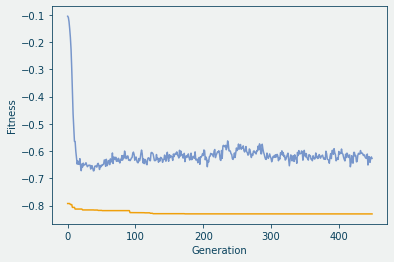

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


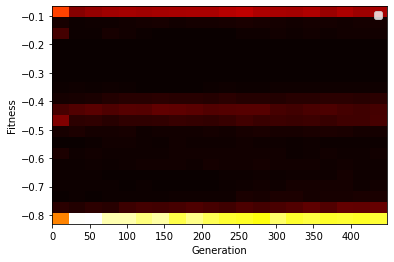

[-0.10544456060677769, -0.10968958636522294, -0.12548659004420043, -0.15175653180181978, -0.18337681397596994, -0.22739837623602807, -0.29760255752212944, -0.38248216487197645, -0.46381251333370094, -0.5121686904684493, -0.5643822902567053, -0.5650747775097962, -0.6006744610114423, -0.6247124187742932, -0.6480275603638886, -0.6366650295686405, -0.6487419578015696, -0.647794385382433, -0.6280038181003146, -0.6551164219099627, -0.6722182560198274, -0.6474237606109259, -0.6588714800555006, -0.6444669599565533, -0.6510180056226454, -0.6512510423571307, -0.6488059288088568, -0.64288857532774, -0.6497602963473742, -0.6576597428955535, -0.6551206473399336, -0.6520560861735798, -0.6519478273146361, -0.652207109871588, -0.6662151070882518, -0.6543525982926123, -0.6537357762698912, -0.6626842081309077, -0.6729215918474742, -0.6715222048155388, -0.6558748594827543, -0.6546608088868097, -0.6557345459588382, -0.6590815120567183, -0.6479034951480765, -0.644983853958873, -0.6538326420888537, -0.66778

In [12]:
def plot_fit(results):
    epochs = np.arange(len(results[0]))
    #print(epochs)
    best_individuals = {}
    averages_all = []
    bests_all = []
    stds_all = []
    best_of_all = []
    stds_best_all = [] 
    indivs = []
    indivs_epochs = []
    indivs_per_epoch = []
    boa_fit = 100000
    boa_indiv = None
    for iteration in epochs:
        averages_all.append([])
        bests_all.append([])
        stds_all.append([])
        indivs_per_epoch.append([])
        best_of_all.append(0)
        stds_best_all.append(0)        
        for result in results:
            all_fits = []
            best = 100000
            gen_best = 100000
            for indiv in result[iteration]:
                indivs.append(indiv['fitness'])
                indivs_epochs.append(iteration)
                indivs_per_epoch[iteration].append(-1 * indiv['fitness'])
                if indiv['fitness'] < best:
                    best = indiv['fitness']
                    if indiv['fitness'] < boa_fit:
                        boa_fit = best
                        print(f'------NEW BEST------\n{iteration}-{indiv["id"]}-{boa_fit}\n{smart_phenotype(indiv["phenotype"])}\n--------------------')
                        best_individuals[iteration] = {"fitness": boa_fit, "phenotype": indiv["phenotype"], "smart_phenotype": smart_phenotype(indiv["phenotype"])}
                best = best if indiv['fitness'] > best else indiv['fitness']
                all_fits.append(indiv['fitness'])
            averages_all[iteration].append(np.average(all_fits))
            stds_all[iteration].append(np.std(all_fits))
            bests_all[iteration].append(best)
        stds_best_all[iteration] = np.std(bests_all[iteration]) 
        stds_all[iteration] = np.std(averages_all[iteration])
        averages_all[iteration] = np.average(averages_all[iteration])
        best_of_all[iteration] = np.min(bests_all[iteration])  
        bests_all[iteration] = np.average(bests_all[iteration]) 
    plt.figure(facecolor='#eff2f1')
    
    ax = plt.axes()
    ax.set_facecolor(color="#eff2f1")
    ax.spines['bottom'].set_color('#08415c')
    ax.spines['top'].set_color('#08415c')
    ax.spines['left'].set_color('#08415c')
    ax.spines['right'].set_color('#08415c')
    ax.xaxis.label.set_color('#08415c')
    ax.yaxis.label.set_color('#08415c')
    ax.tick_params(axis='x', colors='#08415c')
    ax.tick_params(axis='y', colors="#08415c")
    plt.plot(epochs, averages_all, label='population average', color="#7796cb")
    #plt.fill_between(epochs, [i + j for i, j in zip(averages_all, stds_all)], [i - j for i, j in zip(averages_all, stds_all)], alpha=0.2)
    plt.plot(epochs, bests_all, label='best average', color="#EFA00B")   
    #plt.fill_between(epochs, [i + j for i, j in zip(bests_all, stds_best_all)], [i - j for i, j in zip(bests_all, stds_best_all)], alpha=0.2)
    plt.xlabel('Generation')
    plt.ylabel('Fitness')
    plt.savefig(f'best_average_evolution_{run_number}.pdf')
    plt.show()
    
    heatmap_matrix = np.zeros((10, len(epochs)))
    for epoch, fit in zip(indivs_epochs, indivs):
        for index, limit in zip(range(10), np.linspace(10000,0,10)):
            if fit > limit:
                heatmap_matrix[index][epoch] += 1
                break
    heatmap, xedges, yedges = np.histogram2d(indivs_epochs, indivs, bins=20)

    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]


    plt.imshow(heatmap.T, extent=extent, origin='lower', aspect='auto', cmap='hot')


    #plt.plot(epochs, [0.7862666646639506 for i in bests_all], label='fixed lr val_acc')
    #plt.plot(epochs, best_of_all, label='best of all')
    plt.xlabel('Generation')
    plt.ylabel('Fitness')
    plt.legend()
    plt.savefig(f'heatmap{run_number}.pdf')
    plt.show()
    print(averages_all)
    return best_individuals

best_individuals = plot_fit(results)

In [ ]:
smart_phenotype("alpha_func, beta_func, sigma_func, grad_func = lambda shape,  alpha, grad: tf.math.sqrt(tf.constant(9.38616893e-01, shape=shape, dtype=tf.float32)), lambda shape,  alpha, beta, grad: grad, lambda shape,  alpha, beta, sigma, grad: tf.math.subtract(sigma, tf.math.negative(grad)), lambda shape,  alpha, beta, sigma, grad: tf.math.multiply(tf.math.subtract(tf.math.negative(sigma), beta), tf.math.sqrt(tf.constant(7.03711536e-03, shape=shape, dtype=tf.float32)))")

'multiply(subtract(negative(subtract(sigma, negative(grad))), grad), sqrt(constant(7.03711536e-03)))'